# 基于Sagemaker实现亚马逊广告投放效率优化

流程简介
- 环境和源数据准备
- 数据清洗
- 特征工程
- 模型训练
- 模型部署
- 模型推理


## 环境准备
安装一些必要的包

In [1]:
import sys

In [61]:
#!pip install --upgrade pip
#!{sys.executable} -m pip install sagemaker pandas numpy --upgrade
!pip install pytorch_transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
import io
import re
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

事先定义需要用到的其他资源,比如存放数据的s3 bucket,IAM Role

In [4]:
# Define session and bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()

# ----You can modify this prefix-----
prefix = "sagemaker/adsworkshop"

# Define IAM role
from sagemaker import get_execution_role
role = get_execution_role()

In [5]:
bucket

'sagemaker-ap-northeast-1-249517808360'

## 源数据准备

1. 源数据包括 广告投放效果指标数据，产品属性相关信息的数据，折扣相关数据。推荐的列包含：
    - campaign_id
    - keyword_text
    - impressions
    - clicks
    - order
    - sales
    - Bid(or cpc_fee)
    - costs
    - conversion
    - ctrfetch_time
    - listing_id
    - category_name
    - price
    - star
    - review_num
    - quantity
    - rank_keyword_text 
    - discount
2. 在监督学习算法中，训练数据的数量和质量非常重要，建议采取历史三个月或者更多的有效投放数据，poc实验过程可以适当减少数据量。


In [6]:
# load data in s3 with cli
# ----modify bucket with your own bucket----
#!aws s3 cp s3://yourbucket/your-data.csv ./trainset.csv

# load data in s3 with boto3
# ----modify bucket with your own bucket----
#s3 = boto3.client('s3')
#s3.download_file('BUCKET_NAME', 'OBJECT_NAME', 'FILE_NAME')

# load local data 
# ----modify with your own file name----
sample_data =pd.read_csv("./ads_sample.csv")
#sample_data =pd.read_excel("./ads_sample.xlsx")
sample_data

,campaign_id,keyword_text,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,category_name,listing_id,price,star,review_num,quantity,rank_keyword_text,discount,fetch_time
0,820992,Adapter,16049,27,3,14.99,0.91,24.57,0.595943,0.0016,测试路由器,6456262,14.99,4,6,74,15.0,0.698688,2021-11-19
1,216054,WiF,10219,14,3,18.99,1.09,15.19,0.805063,0.0013,router2,859621082,18.99,4,6,56,19.0,0.845032,2021-11-19
2,125902,wifi,570,8,3,18.99,1.75,14.00,0.752556,0.0140,wifi Adapter,150661745,18.99,4,6,85,19.0,0.858499,2021-11-19
3,990944,WiFi,2714,9,5,29.98,1.73,15.61,0.052907,0.0033,Adapter target,87110874,29.98,1,6,51,30.0,0.854347,2021-11-19
4,260917,600M网卡精准词广告5,578,8,3,14.99,2.06,16.49,0.532860,0.0138,测试路由器,571406384,14.99,3,6,61,15.0,0.820196,2021-11-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547,144178,Bluetooth,1398,2,3,15.99,1.06,2.12,0.054626,0.0014,Adapter target,980721559561,15.99,3,12,78,16.0,0.779643,2022-07-18
9548,144254,Brand,4621,8,3,23.19,1.25,10.02,0.770752,0.0017,Adapter,230579922424,23.19,3,8,39,23.0,0.531520,2022-07-18
9549,184683,600兆mini,339,3,3,12.74,1.30,3.90,0.659693,0.0088,WIFI test,73573020,12.74,1,6,88,13.0,0.855904,2022-07-18
9550,270747,Apollo-SBV-Microfiber-keyword,2174,15,3,23.19,0.90,13.52,0.753400,0.0068,IPV6,813462820,23.19,4,8,20,23.0,0.841597,2022-07-18


In [7]:
sample_data.dtypes

campaign_id            int64
keyword_text          object
impressions            int64
clicks                 int64
order                  int64
sales                float64
cpc_fee              float64
costs                float64
conversion           float64
ctr                  float64
category_name         object
listing_id             int64
price                float64
star                   int64
review_num             int64
quantity               int64
rank_keyword_text    float64
discount             float64
fetch_time            object
dtype: object

In [8]:
sample_data.iloc[0,:]

campaign_id              820992
keyword_text            Adapter
impressions               16049
clicks                       27
order                         3
sales                     14.99
cpc_fee                    0.91
costs                     24.57
conversion             0.595943
ctr                      0.0016
category_name             测试路由器
listing_id              6456262
price                     14.99
star                          4
review_num                    6
quantity                     74
rank_keyword_text          15.0
discount               0.698688
fetch_time           2021-11-19
Name: 0, dtype: object

## 数据探索与数据清洗
1. 去除异常值和缺失值
2. 查看数据相关性

In [9]:
# data rows
sample_data.shape[0]

9552

In [10]:
# Statistics for NaN 
print(sample_data.isna().sum())

for i in sample_data.isna().sum():
    if i/sample_data.shape[0] > 0.5:
        print(" NaN is too much, you need correct your data")

campaign_id          0
keyword_text         0
impressions          0
clicks               0
order                0
sales                0
cpc_fee              0
costs                0
conversion           0
ctr                  0
category_name        0
listing_id           0
price                0
star                 0
review_num           0
quantity             0
rank_keyword_text    0
discount             0
fetch_time           0
dtype: int64


In [11]:
# outlier check 
# Using pandas describe() to find outliers
sample_data.describe()


,campaign_id,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,listing_id,price,star,review_num,quantity,rank_keyword_text,discount
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9.552000e+03,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,327963.545959,4627.287688,18.268425,5.105318,59.458915,1.064820,15.915650,0.453370,0.007389,1.809319e+10,59.458915,2.497069,12.409024,51.753245,59.475398,0.698824
std,249116.125458,6201.989108,24.006603,4.238345,72.763274,0.491736,14.853349,0.257631,0.009613,9.857706e+10,72.763274,1.122668,5.664317,28.919812,72.772134,0.115643
min,100575.000000,0.000000,0.000000,3.000000,5.590000,0.000000,0.000000,0.010133,0.000000,1.477100e+04,5.590000,1.000000,4.000000,2.000000,6.000000,0.500015
25%,156228.000000,1231.750000,7.000000,3.000000,19.990000,0.660000,6.640000,0.230285,0.002500,4.630114e+07,19.990000,1.000000,8.000000,27.000000,20.000000,0.599524
50%,219154.000000,2854.000000,12.000000,3.000000,34.990000,1.080000,12.050000,0.449521,0.004500,2.206292e+08,34.990000,2.000000,9.000000,52.000000,35.000000,0.696715
75%,424191.000000,5614.750000,20.000000,5.000000,69.982500,1.370000,19.982500,0.678867,0.008500,6.412204e+08,69.982500,4.000000,17.000000,76.000000,70.000000,0.799920
max,996017.000000,124397.000000,373.000000,75.000000,1629.870000,7.670000,228.690000,0.899970,0.250000,9.924784e+11,1629.870000,4.000000,22.000000,102.000000,1630.000000,0.899999


In [12]:
# percentile capping
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
quantile = sample_data.cpc_fee.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
for i in qValues:
    print("{} percentile value of ads fare is {}".format(int(i*100), quantile[i]))

91 percentile value of ads fare is 1.7
92 percentile value of ads fare is 1.73
93 percentile value of ads fare is 1.77
94 percentile value of ads fare is 1.81
95 percentile value of ads fare is 1.86
96 percentile value of ads fare is 1.93
97 percentile value of ads fare is 2.0
98 percentile value of ads fare is 2.12
99 percentile value of ads fare is 2.39
100 percentile value of ads fare is 7.67


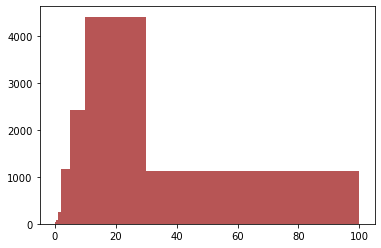

In [13]:

import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4)) #新建画布
# ----you can modify with others feature----
plt.hist(sample_data['costs'],bins = [0, 0.5,1,2, 5, 10, 30,100],color='brown', alpha = 0.8, label = "直方图" ) #绘制直方图

plt.show()

In [14]:
#print("The proportion of cpc_fee greater than 5 is ", data[data['cpc_fee']>=5].shape[0]/df.shape[0])
#df_fee =data[data['cpc_fee']>=5]
sample_data.corr()

,campaign_id,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,listing_id,price,star,review_num,quantity,rank_keyword_text,discount
campaign_id,1.000000,-0.025843,0.017953,0.003516,-0.007716,0.008477,0.010314,-0.013234,-0.038778,-0.134532,-0.007716,0.004471,-0.008266,0.000782,-0.007728,0.004227
impressions,-0.025843,1.000000,0.598725,0.355294,0.218208,-0.095853,0.516828,0.000493,-0.270952,-0.018598,0.218208,0.003491,-0.016227,0.024729,0.218233,-0.010218
clicks,0.017953,0.598725,1.000000,0.645564,0.433007,-0.299528,0.759597,0.008290,0.062763,0.034444,0.433007,-0.009411,0.197739,0.003441,0.433013,0.004493
order,0.003516,0.355294,0.645564,1.000000,0.551053,-0.069612,0.579132,0.015582,0.052077,0.075984,0.551053,-0.022709,0.054849,0.001939,0.551096,0.001182
sales,-0.007716,0.218208,0.433007,0.551053,1.000000,-0.032535,0.386389,0.005970,0.111236,0.027880,1.000000,-0.014300,0.253268,0.002261,0.999999,0.002921
cpc_fee,0.008477,-0.095853,-0.299528,-0.069612,-0.032535,1.000000,0.131919,0.016848,-0.129117,-0.005783,-0.032535,-0.009909,-0.525996,0.022398,-0.032567,-0.003863
costs,0.010314,0.516828,0.759597,0.579132,0.386389,0.131919,1.000000,0.020387,-0.001080,0.089773,0.386389,-0.007367,-0.122728,0.012584,0.386385,-0.002821
conversion,-0.013234,0.000493,0.008290,0.015582,0.005970,0.016848,0.020387,1.000000,0.000357,0.000705,0.005970,-0.004817,-0.015305,0.012469,0.005981,-0.014196
ctr,-0.038778,-0.270952,0.062763,0.052077,0.111236,-0.129117,-0.001080,0.000357,1.000000,0.009466,0.111236,0.006230,0.203126,-0.022758,0.111245,0.013731
listing_id,-0.134532,-0.018598,0.034444,0.075984,0.027880,-0.005783,0.089773,0.000705,0.009466,1.000000,0.027880,-0.005574,0.010264,-0.009145,0.027902,0.014633


<AxesSubplot:>

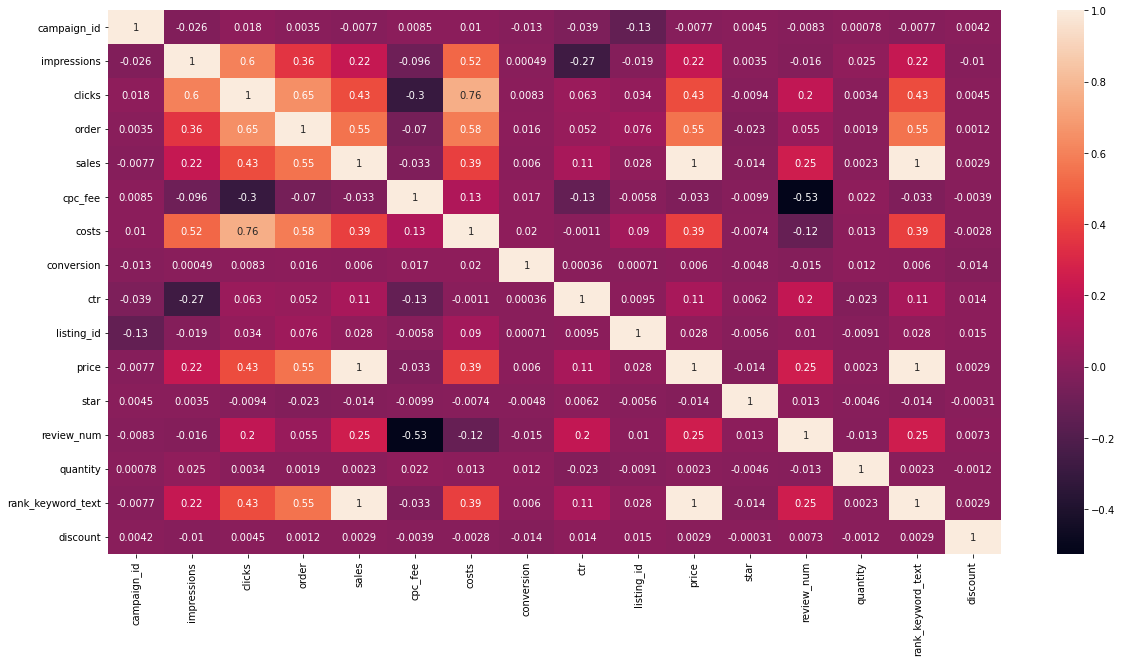

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(figsize = (20, 10))
sns.heatmap(sample_data.corr(),annot=True)

### 筛选指定列
本次实验参考用到的列：['campaign_id','keyword_text','impressions','clicks','order','sales','cpc_fee','costs','conversion','ctr','list_id','category_name','price','star','review_num','quantity','rank_keyword_text','discount','fetch_time']

In [16]:
# existing column
data = sample_data.copy()
index = data.columns.tolist()
index

['campaign_id',
 'keyword_text',
 'impressions',
 'clicks',
 'order',
 'sales',
 'cpc_fee',
 'costs',
 'conversion',
 'ctr',
 'category_name',
 'listing_id',
 'price',
 'star',
 'review_num',
 'quantity',
 'rank_keyword_text',
 'discount',
 'fetch_time']

In [17]:
# drop the column not processed in this poc
## index_diff
features = ['campaign_id','keyword_text','impressions','clicks','order','sales','cpc_fee','costs','conversion','ctr','category_name','listing_id','price','star','review_num','quantity','rank_keyword_text','discount','fetch_time']
index = data.columns.tolist()
drop_features = [i for i in index if not i in features]
print('feature need to be dropped:')
print(str(drop_features))
print('these future is in your index, but not in our poc target, you can use these features in your future demo')

feature need to be dropped:
[]
these future is in your index, but not in our poc target, you can use these features in your future demo


In [18]:
def dataprocess(data):
    
    print ("Filter cloumn-->")
    data = data[['campaign_id','keyword_text','impressions','clicks','order','sales','cpc_fee','costs','conversion','ctr',
                 'category_name','price','star','review_num','quantity','rank_keyword_text','discount','fetch_time']]
    
    print ("Filter 0-->")
    data = data[(data.impressions >0)]
    data = data[(data.clicks >0)]
    data = data[(data.cpc >0)]
    data = data[(data.rank_psbsds >0)]
    
    
    #print ("Filter not sb ads -->")
    #dataf = new_data[new_data['matchtype']=='BROAD']
    print ("Filter NaN-->")
    data = data.dropna(axis=0)
      
    
    return data

In [19]:
if len(drop_features)>0:
    for feature in drop_features:
        data.drop(feature, inplace=True, axis=1)

In [20]:
print(len(features),len(index))

19 19


In [21]:
print('columns in raw data:')
print(len(sample_data.columns.tolist()))
print('columns in cleaned data:')
print(len(data.columns.tolist()))

columns in raw data:
19
columns in cleaned data:
19


### 指定列类型


In [22]:
def convert_types(df):
    df["campaign_id"] = df["campaign_id"].astype("object")
    df["listing_id"] = df["listing_id"].astype("object")
    
    #df["adv_group_id"] = df["adv_group_id"].astype("object")
    #df["match_type"] = df["match_type"].astype("category")
    return df
    
def format_db_dataframe(df):
    df["date_time"] = pd.to_datetime(df['date_time'])
    #df["report_date"] = pd.to_datetime(df['report_date'])
    #df["create_time"] = pd.to_datetime(df['create_time'])
#     df.drop(columns=['id',"adv_type","account"], inplace=True, axis=1)
    print('data shape by format:', df.shape)
    return df


In [23]:
data.rename(columns = {'fetch_time':'date_time'}, inplace=True)
df = format_db_dataframe(data)
df  = convert_types(df)
# 注意列的类型
df.dtypes

data shape by format: (9552, 19)


campaign_id                  object
keyword_text                 object
impressions                   int64
clicks                        int64
order                         int64
sales                       float64
cpc_fee                     float64
costs                       float64
conversion                  float64
ctr                         float64
category_name                object
listing_id                   object
price                       float64
star                          int64
review_num                    int64
quantity                      int64
rank_keyword_text           float64
discount                    float64
date_time            datetime64[ns]
dtype: object

In [24]:
df.describe()

,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,price,star,review_num,quantity,rank_keyword_text,discount
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,4627.287688,18.268425,5.105318,59.458915,1.064820,15.915650,0.453370,0.007389,59.458915,2.497069,12.409024,51.753245,59.475398,0.698824
std,6201.989108,24.006603,4.238345,72.763274,0.491736,14.853349,0.257631,0.009613,72.763274,1.122668,5.664317,28.919812,72.772134,0.115643
min,0.000000,0.000000,3.000000,5.590000,0.000000,0.000000,0.010133,0.000000,5.590000,1.000000,4.000000,2.000000,6.000000,0.500015
25%,1231.750000,7.000000,3.000000,19.990000,0.660000,6.640000,0.230285,0.002500,19.990000,1.000000,8.000000,27.000000,20.000000,0.599524
50%,2854.000000,12.000000,3.000000,34.990000,1.080000,12.050000,0.449521,0.004500,34.990000,2.000000,9.000000,52.000000,35.000000,0.696715
75%,5614.750000,20.000000,5.000000,69.982500,1.370000,19.982500,0.678867,0.008500,69.982500,4.000000,17.000000,76.000000,70.000000,0.799920
max,124397.000000,373.000000,75.000000,1629.870000,7.670000,228.690000,0.899970,0.250000,1629.870000,4.000000,22.000000,102.000000,1630.000000,0.899999


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


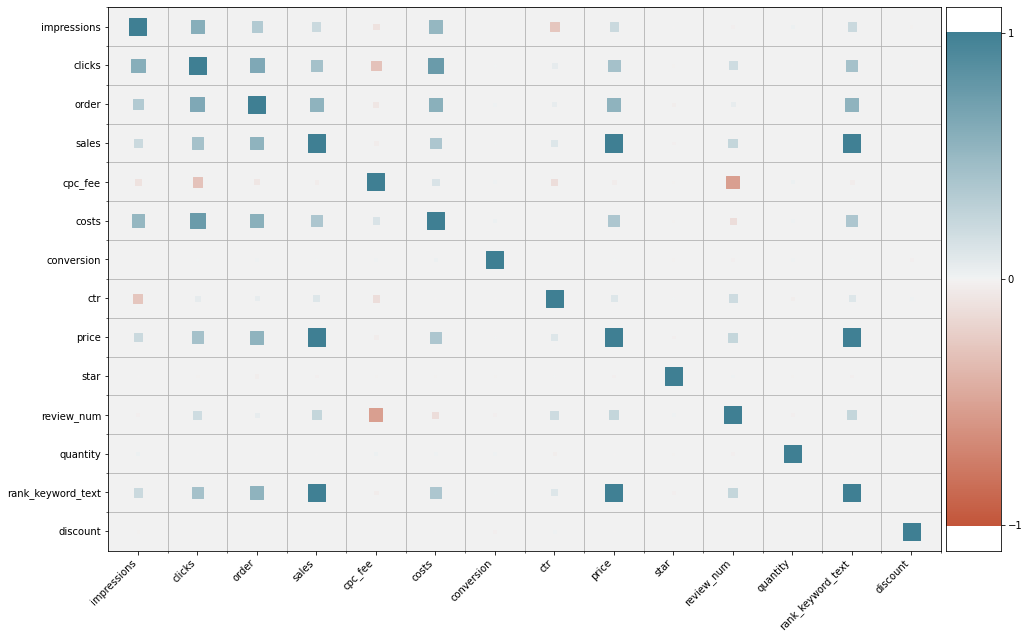

In [25]:
!pip install heatmapz
from heatmap import heatmap, corrplot
plt.figure(figsize=(16, 10))
corrplot(df.corr(), size_scale=300)

### 数据可视化

col_0,% observations
campaign_id,
100575,0.000838
100806,0.000314
101008,0.000105
101409,0.000209
101697,0.000628
...,...
978922,0.001361
984737,0.000523
988578,0.000105


col_0,% observations
keyword_text,
1,0.003978
1-DS-B07QCMSXDQ,0.000419
1-DS-B07QGSC6MV,0.000105
1-reflective,0.010574
1200/1900,0.008794
...,...
绿色自动广告,0.004292
遥控车-广泛,0.000105
遥控车-自动,0.000209


col_0,% observations
category_name,
600m router,0.043132
700m router,0.015075
800m router,0.014866
900m router,0.015389
Adapter,0.027429
Adapter target,0.031198
Adapter target contorl,0.016122
Adapter target fast,0.016436
Adapter target test,0.015075


col_0,% observations
listing_id,
14771,0.001361
373618,0.000105
610862,0.002408
1081779,0.000209
1347286,0.002408
...,...
754636343995,0.000419
814013686701,0.000105
898259947210,0.001047


,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,price,star,review_num,quantity,rank_keyword_text,discount
count,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000,9552.000000
mean,4627.287688,18.268425,5.105318,59.458915,1.064820,15.915650,0.453370,0.007389,59.458915,2.497069,12.409024,51.753245,59.475398,0.698824
std,6201.989108,24.006603,4.238345,72.763274,0.491736,14.853349,0.257631,0.009613,72.763274,1.122668,5.664317,28.919812,72.772134,0.115643
min,0.000000,0.000000,3.000000,5.590000,0.000000,0.000000,0.010133,0.000000,5.590000,1.000000,4.000000,2.000000,6.000000,0.500015
25%,1231.750000,7.000000,3.000000,19.990000,0.660000,6.640000,0.230285,0.002500,19.990000,1.000000,8.000000,27.000000,20.000000,0.599524
50%,2854.000000,12.000000,3.000000,34.990000,1.080000,12.050000,0.449521,0.004500,34.990000,2.000000,9.000000,52.000000,35.000000,0.696715
75%,5614.750000,20.000000,5.000000,69.982500,1.370000,19.982500,0.678867,0.008500,69.982500,4.000000,17.000000,76.000000,70.000000,0.799920
max,124397.000000,373.000000,75.000000,1629.870000,7.670000,228.690000,0.899970,0.250000,1629.870000,4.000000,22.000000,102.000000,1630.000000,0.899999


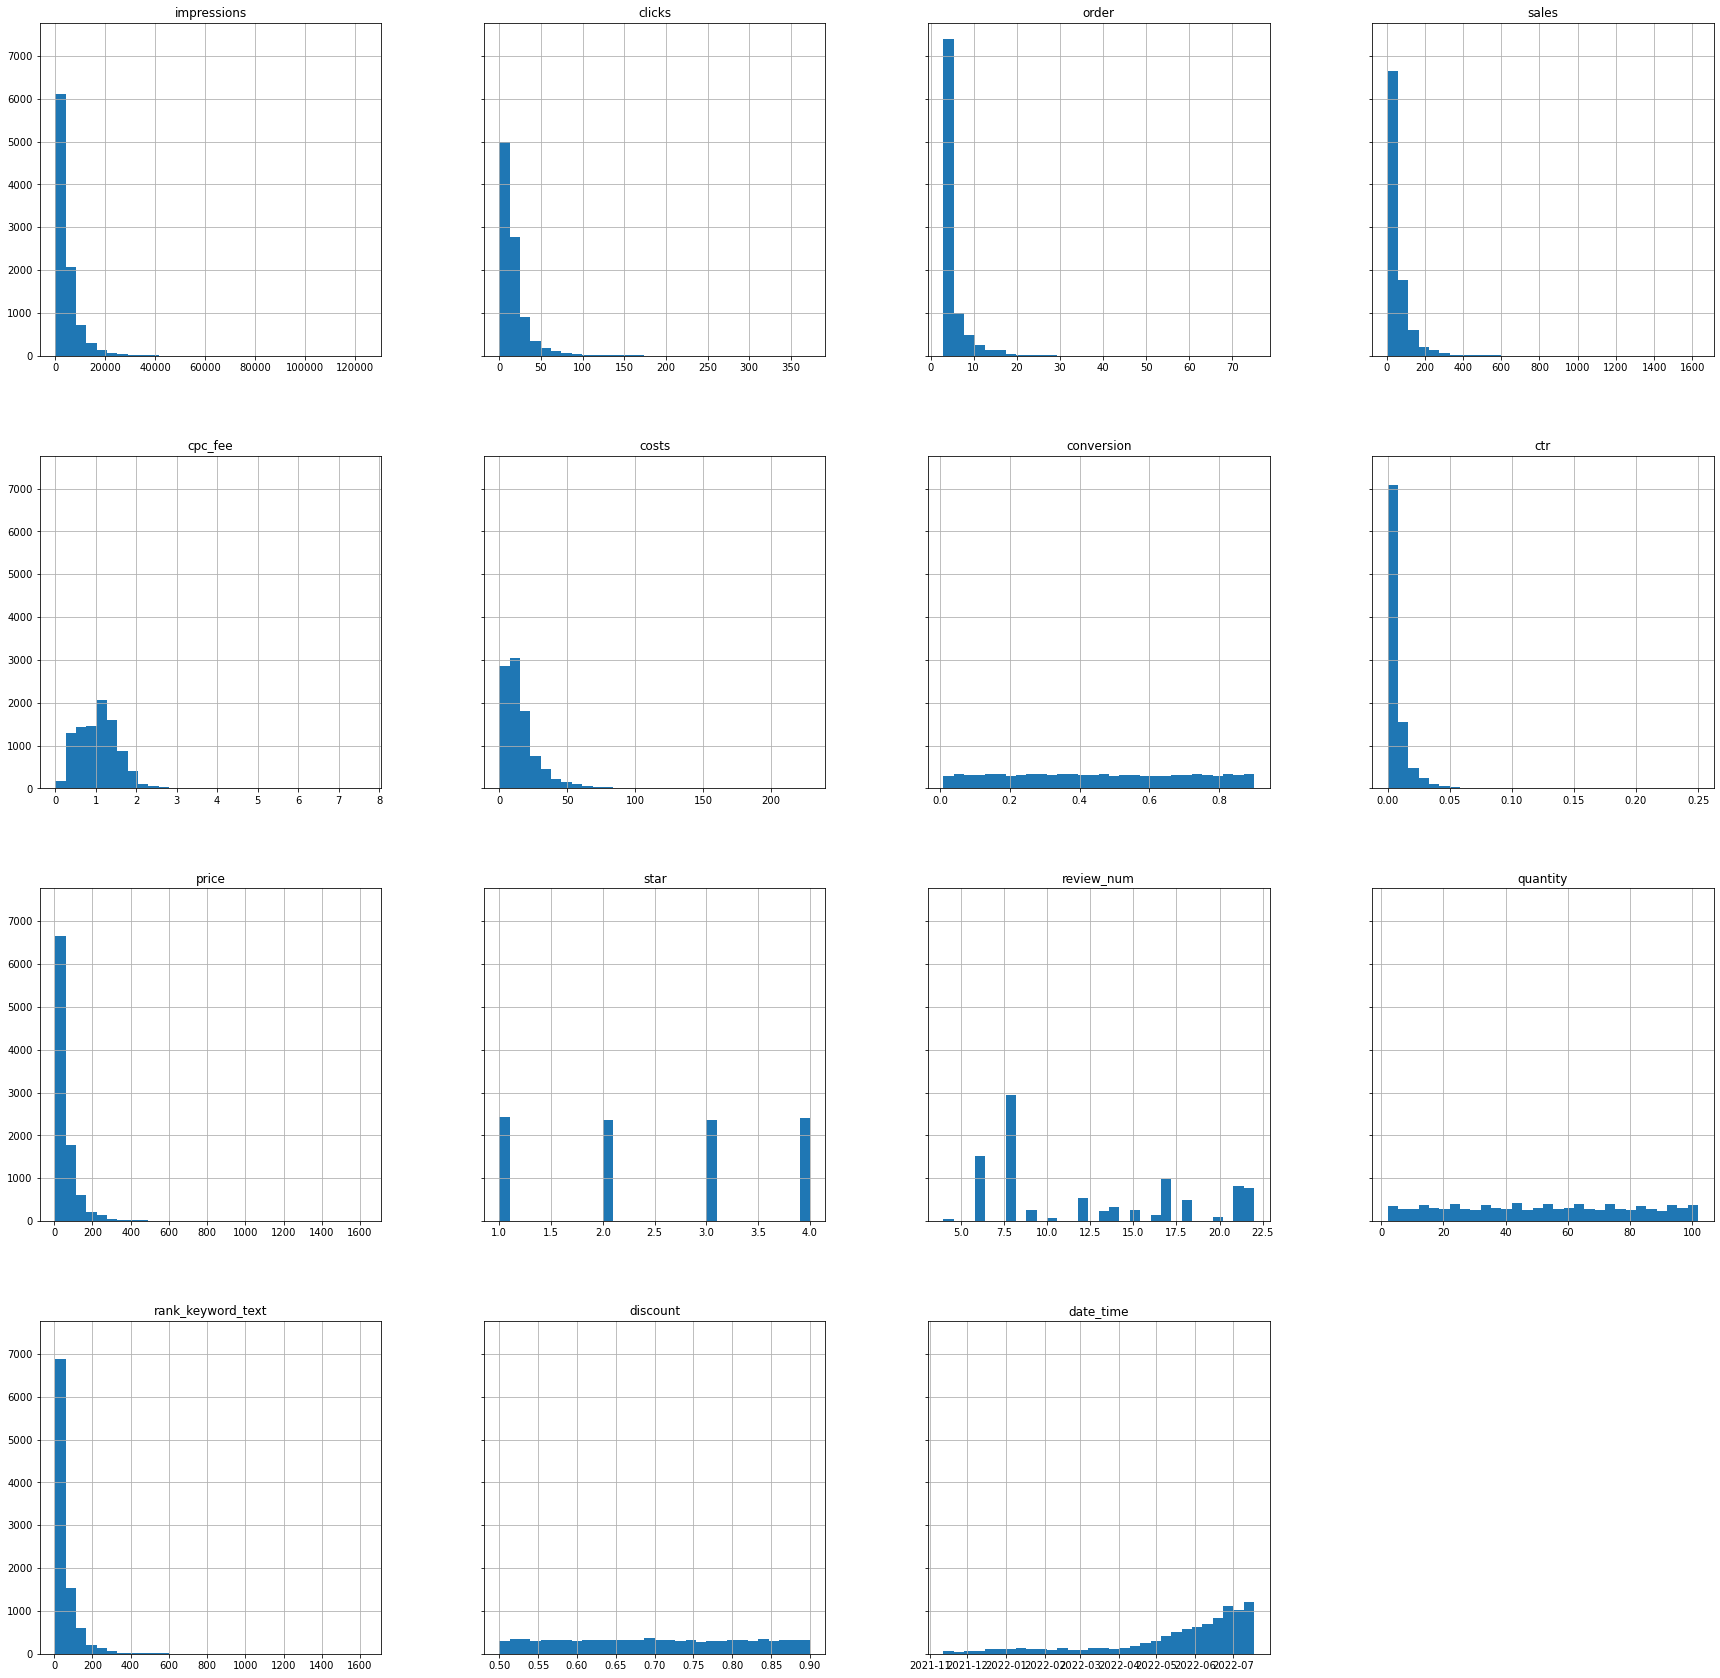

In [26]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=["object",'category']).columns:
    display(pd.crosstab(index=df[column], columns="% observations", normalize="columns"))
    
    
# Histograms for each numeric features
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(30, 30))

## 数据特征工程
- 基于时间戳增加时间相关特征
- bert做文本类特征信息提取
- 滑窗累积过去销量订单，评论等


1. 数值类特征：
    - Clicks,int64
    - discount,float64
    - sales_price,float64
    - star
    <br> <br/>
2. 从订单时间生成的时间特征：['month', 'weekday', 'quarter'] <br/>
    如果只有过去两三个月的数据时，month的值只会有两三个，quarter可能只有一个最后可以不用于训练
    - month
    - weekday
    - quarter
    <br> <br/>
3. 需要通过One-hot处理分类特征：['asin', 'campaign_type', 'Brand', 'Label', 'ProductGroup', 'ProductTypeName', 'AdType']<br/>
    一些属性类信息也可以用bert做特征处理，可能列会更多
    - asin
    - campaign_type, 代表不同类别的campaign，秒杀/秒杀等，也有客户写的1，2，3
    - Brand
    - Label
    - ProductGroup
    - ProductTypeName
    - AdType,代表广告类别，sp,sd,sb,sbv,none
    - month，weekday,quarter也需要做onehot
    <br> <br/>
4. 通过滑窗获得过去3/5/7天统计信息的特征：['GMV', 'sales', 'AttributedSales7d', 'AttributedConversions1d', 'Clicks'],['costs', 'sales', 'orders', 'conversion', 'clicks']
    - review_num
    - sales
    - AttributedSales7d
    - AttributedConversions1d
    - Clicks

#### 添加时间相关特征

In [27]:
import calendar

def add_time_hollday(df):
    # time feature, weekday/month/quarter
    df['weekday'] = df['date_time'].map(lambda x: x.dayofweek)
    df['weekend'] = df['date_time'].map(lambda x: judge_weekend(x))
    df['month'] = df['date_time'].map(lambda x: x.month)
    df['quater'] = df['date_time'].map(lambda x: x.quarter)
    df['holiday_type'] = df['date_time'].map(lambda x: judge_holiday(x))
    return df

def judge_weekend(date):
    if date.weekday() > 5:
        return 'weekend'
    else:
        return 'weekday'

def judge_holiday(date):
    # thanks-giving
    if date.month == 11:
        if get_thanksgiving(date.year) == date.day:
            return 'thanksgiving'
        elif get_thanksgiving(date.year) + 1 == date.day:
            return 'blackfirday'
        return 'normal'
    elif date.month == 12 and date.day == 25:
        return 'chirsmas'
    else:
        return 'normal'


def get_thanksgiving(year):
    month = 11
    thursday = 4
    date_value_index = 0
    cal = calendar.Calendar(firstweekday=6)

    weeks = cal.monthdays2calendar(year, month)
    week_index = 3
    if weeks[0][thursday][date_value_index] == 0:
        week_index += 1
    result = weeks[week_index][thursday][date_value_index]
    # print("{}年的感恩节是：11月{}日".format(year, str(result).zfill(2)))
    return result

In [28]:
data_addtime =add_time_hollday(df)
data_addtime

,campaign_id,keyword_text,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,...,review_num,quantity,rank_keyword_text,discount,date_time,weekday,weekend,month,quater,holiday_type
0,820992,Adapter,16049,27,3,14.99,0.91,24.57,0.595943,0.0016,...,6,74,15.0,0.698688,2021-11-19,4,weekday,11,4,normal
1,216054,WiF,10219,14,3,18.99,1.09,15.19,0.805063,0.0013,...,6,56,19.0,0.845032,2021-11-19,4,weekday,11,4,normal
2,125902,wifi,570,8,3,18.99,1.75,14.00,0.752556,0.0140,...,6,85,19.0,0.858499,2021-11-19,4,weekday,11,4,normal
3,990944,WiFi,2714,9,5,29.98,1.73,15.61,0.052907,0.0033,...,6,51,30.0,0.854347,2021-11-19,4,weekday,11,4,normal
4,260917,600M网卡精准词广告5,578,8,3,14.99,2.06,16.49,0.532860,0.0138,...,6,61,15.0,0.820196,2021-11-19,4,weekday,11,4,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547,144178,Bluetooth,1398,2,3,15.99,1.06,2.12,0.054626,0.0014,...,12,78,16.0,0.779643,2022-07-18,0,weekday,7,3,normal
9548,144254,Brand,4621,8,3,23.19,1.25,10.02,0.770752,0.0017,...,8,39,23.0,0.531520,2022-07-18,0,weekday,7,3,normal
9549,184683,600兆mini,339,3,3,12.74,1.30,3.90,0.659693,0.0088,...,6,88,13.0,0.855904,2022-07-18,0,weekday,7,3,normal
9550,270747,Apollo-SBV-Microfiber-keyword,2174,15,3,23.19,0.90,13.52,0.753400,0.0068,...,8,20,23.0,0.841597,2022-07-18,0,weekday,7,3,normal


#### 添加滑窗特征

In [29]:
def get_past_features(feature_name, df_res_4):
    groups = df_res_4.groupby(['campaign_id', 'keyword_text'])[feature_name]
    #groups = df_res_4.groupby(['id','campaign_id', 'keyword_text'])[feature_name]
    # groups.to_csv("./demo.cvs")
    # past n day lag feature, rolling window feature
    for i in [1,3,7]:
        if i>1:
            df_res_4[f'rolling_sum_{i}_{feature_name}'] = groups.rolling(i).sum().reset_index()[feature_name]
        df_res_4[f'Lag_{i}_{feature_name}'] = groups.shift(i)
        df_res_4[f'rolling_mean_{i}_{feature_name}'] = groups.rolling(i).mean().reset_index()[feature_name]

def add_time_feature(df_res_4):
    #if set(["rank", "price", "quantity"]) < set(df_res_4.columns.tolist()):
        #coumns = ['costs','sales', 'conversion',"impressions", 'price', 'rank', 'quantity',"discount","review_num"]
    #else:
        #coumns = ['costs', 'sales', 'orders', 'conversion', 'clicks']
    #  add past 1 day, 1 week, 1 year avg quantity, conversion
    coumns = ['clicks',"order","impressions"]
    df_res_4 = df_res_4.sort_values(by=['campaign_id', "keyword_text", 'date_time']).reset_index(
        drop=True)
    #df_res_4 = df_res_4.sort_values(by=['id', 'campaign_id', "keyword_text", 'create_time']).reset_index(
        #drop=True)
    for i in coumns:
        get_past_features(i, df_res_4)
    return df_res_4


In [30]:
data_addpast = add_time_feature(data_addtime)
data_addpast

,campaign_id,keyword_text,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,...,Lag_7_order,rolling_mean_7_order,Lag_1_impressions,rolling_mean_1_impressions,rolling_sum_3_impressions,Lag_3_impressions,rolling_mean_3_impressions,rolling_sum_7_impressions,Lag_7_impressions,rolling_mean_7_impressions
0,100575,S20-G-Auto紧密-0617,645,4,3,119.99,0.93,3.70,0.615365,0.0062,...,NaN,NaN,NaN,645.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100575,S20-G-Auto紧密-0617,480,1,5,239.98,1.00,1.00,0.056868,0.0020,...,NaN,NaN,645.0,480.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100575,S20-G-Auto紧密-0617,3628,6,3,119.99,0.97,5.80,0.074291,0.0016,...,NaN,NaN,480.0,3628.0,4753.0,NaN,1584.333333,NaN,NaN,NaN
3,100575,S20-G-Auto紧密-0617,8427,20,9,383.96,0.96,19.22,0.641231,0.0023,...,NaN,NaN,3628.0,8427.0,12535.0,645.0,4178.333333,NaN,NaN,NaN
4,100575,S20-G-Auto紧密-0617,8418,21,7,287.97,0.94,19.69,0.698041,0.0024,...,NaN,NaN,8427.0,8418.0,20473.0,480.0,6824.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547,996017,RES,663,3,3,16.99,1.22,3.67,0.593170,0.0045,...,NaN,NaN,164.0,663.0,1171.0,587.0,390.333333,NaN,NaN,NaN
9548,996017,RES,379,2,3,28.99,1.35,2.69,0.883565,0.0052,...,NaN,NaN,663.0,379.0,1206.0,344.0,402.000000,NaN,NaN,NaN
9549,996017,RES,395,4,3,16.99,1.45,5.81,0.594801,0.0101,...,NaN,3.000000,379.0,395.0,1437.0,164.0,479.000000,3277.0,NaN,468.142857
9550,996017,RES,469,3,3,17.99,1.45,4.36,0.820027,0.0063,...,3.0,3.000000,395.0,469.0,1243.0,663.0,414.333333,3001.0,745.0,428.714286


In [31]:
data_addpast.dtypes

campaign_id                           object
keyword_text                          object
impressions                            int64
clicks                                 int64
order                                  int64
sales                                float64
cpc_fee                              float64
costs                                float64
conversion                           float64
ctr                                  float64
category_name                         object
listing_id                            object
price                                float64
star                                   int64
review_num                             int64
quantity                               int64
rank_keyword_text                    float64
discount                             float64
date_time                     datetime64[ns]
weekday                                int64
weekend                               object
month                                  int64
quater    

In [32]:
# bert infer
import torch
from torch import nn
from pytorch_transformers import BertModel, BertConfig, BertTokenizer

class BertTextNet(nn.Module):
    def __init__(self, code_length):
        super(BertTextNet, self).__init__()

        modelConfig = BertConfig.from_pretrained('bert-base-uncased')
        self.textExtractor = BertModel.from_pretrained('bert-base-uncased')
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, tokens, segments, input_masks):
        output = self.textExtractor(tokens, token_type_ids=segments,
                                    attention_mask=input_masks)
        text_embeddings = output[0][:, 0, :]
        # output[0](batch size, sequence length, model hidden dimension)

        return text_embeddings


def get_embedding_torch_tensor(tokenizer, textNet, texts):
    tokens, segments, input_masks = [], [], []
    for text in texts:
        texts = "[CLS] " + text + " [SEP]"
        tokenized_text = tokenizer.tokenize(texts)  # 用tokenizer对句子分词
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)  # 索引列表
        tokens.append(indexed_tokens)
        segments.append([0] * len(indexed_tokens))
        input_masks.append([1] * len(indexed_tokens))

    max_len = max([len(single) for single in tokens])  # 最大的句子长度

    for j in range(len(tokens)):
        padding = [0] * (max_len - len(tokens[j]))
        tokens[j] += padding
        segments[j] += padding
        input_masks[j] += padding
    # segments列表全0，因为只有一个句子1，没有句子2
    # input_masks列表1的部分代表句子单词，而后面0的部分代表paddig，只是用于保持输入整齐，没有实际意义。
    # 相当于告诉BertModel不要利用后面0的部分

    # 转换成PyTorch tensors
    tokens_tensor = torch.tensor(tokens)
    segments_tensors = torch.tensor(segments)
    input_masks_tensors = torch.tensor(input_masks)

    # ——————提取文本特征——————
    text_hashCodes = textNet(tokens_tensor, segments_tensors, input_masks_tensors)  # text_hashCodes是一个32-dim文本特征
    # print(text_hashCodes)
    return text_hashCodes


def get_embedding_df(tokenizer, textNet, texts, feature_name):
    text_hashCodes = get_embedding_torch_tensor(tokenizer, textNet, texts)
    x = text_hashCodes.detach().numpy()
    res = pd.DataFrame(x)
    res.columns = [feature_name + '_' + str(i) for i in range(768)]
    res.insert(0, 'key', texts)  # todo 添加到指定位置
    return res

In [33]:
from pytorch_transformers import BertModel, BertConfig, BertTokenizer
# 针对文本特征(投放关键词, 投放类目名), 利用nlp中的bert模型,获取pretrain embedding(n*32)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
textNet = BertTextNet(code_length=32)

category_df = get_embedding_df(tokenizer,textNet,texts = data_addpast['category_name'].unique(),feature_name = 'category')
keyword_df = get_embedding_df(tokenizer,textNet,texts = data_addpast['keyword_text'].unique(),feature_name = 'keyword')

In [34]:
data5 = pd.merge(data_addpast,keyword_df,left_on='keyword_text',right_on='key')
data_res = pd.merge(data5,category_df,left_on='category_name',right_on='key')
data_res

,campaign_id,keyword_text,impressions,clicks,order,sales,cpc_fee,costs,conversion,ctr,...,category_758,category_759,category_760,category_761,category_762,category_763,category_764,category_765,category_766,category_767
0,100575,S20-G-Auto紧密-0617,645,4,3,119.99,0.93,3.70,0.615365,0.0062,...,0.424928,-0.471749,0.247390,0.105111,0.211803,0.029609,0.062836,-0.311670,-0.235395,0.503476
1,137149,RES,3841,21,11,94.45,1.42,29.90,0.706170,0.0054,...,0.424928,-0.471749,0.247390,0.105111,0.211803,0.029609,0.062836,-0.311670,-0.235395,0.503476
2,137149,RES,7125,20,3,29.99,1.25,25.03,0.673317,0.0028,...,0.424928,-0.471749,0.247390,0.105111,0.211803,0.029609,0.062836,-0.311670,-0.235395,0.503476
3,137149,RES,46,1,3,28.99,1.36,1.36,0.565327,0.0217,...,0.424928,-0.471749,0.247390,0.105111,0.211803,0.029609,0.062836,-0.311670,-0.235395,0.503476
4,140440,RES,9903,33,5,44.08,1.50,49.47,0.848365,0.0033,...,0.424928,-0.471749,0.247390,0.105111,0.211803,0.029609,0.062836,-0.311670,-0.235395,0.503476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547,826276,600M网卡手动2组,1663,14,7,44.97,1.03,14.47,0.199435,0.0084,...,0.240814,-0.306257,0.063752,0.071257,0.065616,0.248944,0.050724,-0.405196,-0.202981,0.429080
9548,826276,600M网卡手动2组,17282,31,13,89.94,0.98,30.34,0.621235,0.0017,...,0.240814,-0.306257,0.063752,0.071257,0.065616,0.248944,0.050724,-0.405196,-0.202981,0.429080
9549,834967,CR160ASIN定位,3146,21,3,27.99,0.97,20.34,0.271033,0.0066,...,0.240814,-0.306257,0.063752,0.071257,0.065616,0.248944,0.050724,-0.405196,-0.202981,0.429080
9550,939576,1300兆磨砂长款-精准,5194,7,3,19.99,1.51,10.57,0.417211,0.0013,...,0.240814,-0.306257,0.063752,0.071257,0.065616,0.248944,0.050724,-0.405196,-0.202981,0.429080


In [35]:
data_res.dtypes

campaign_id      object
keyword_text     object
impressions       int64
clicks            int64
order             int64
                 ...   
category_763    float32
category_764    float32
category_765    float32
category_766    float32
category_767    float32
Length: 1586, dtype: object

In [36]:
data_addword = data_res.copy()

In [37]:
li_sparse_features = data_res.select_dtypes(include=["object",'category']).columns
text_feature = ['category_name','keyword_text','key_x','key_y']
li_sparse_features = [i for i in li_sparse_features if not i in text_feature]
time_features = ['weekday','month','quater']
sparse_features = li_sparse_features + time_features
sparse_features

['campaign_id',
 'listing_id',
 'weekend',
 'holiday_type',
 'weekday',
 'month',
 'quater']

In [38]:
# 对离散特征进行one_hot
#sparse_features = ["campaign_id",'weekday','month','weekend', 'holiday_type','quater']
for feature in sparse_features:
    dummy_df = pd.get_dummies(data_res[feature], prefix=feature)
    print(data_res.shape, dummy_df.shape)
    data_res = pd.concat((data_res, dummy_df), axis=1)
    print(data_res.shape)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


(9552, 1586) (9552, 698)
(9552, 2284)
(9552, 2284) (9552, 699)
(9552, 2983)
(9552, 2983) (9552, 2)
(9552, 2985)
(9552, 2985) (9552, 4)
(9552, 2989)
(9552, 2989) (9552, 7)
(9552, 2996)
(9552, 2996) (9552, 9)
(9552, 3005)
(9552, 3005) (9552, 4)
(9552, 3009)


In [39]:
data_onehot = data_res.copy()
len(data_onehot.columns.tolist())

3009

In [40]:
# coumns = ['clicks',"order","impressions"]
rolling_feature = ['clicks',"order","impressions"]
target_feature = ["order"]
data_feature = ['date_time']
useless = sparse_features + text_feature +rolling_feature +data_feature 
useless = set(useless)-set(target_feature)
useless

{'campaign_id',
 'category_name',
 'clicks',
 'date_time',
 'holiday_type',
 'impressions',
 'key_x',
 'key_y',
 'keyword_text',
 'listing_id',
 'month',
 'quater',
 'weekday',
 'weekend'}

In [41]:
data_final=data_onehot.copy(deep=True)
#keep 'cpc_fee','total_order','clicks'
#过滤无效特征
for feature in useless:
    data_final.drop(feature, axis=1, inplace=True)

In [42]:
# list(data_final.columns.values)

In [43]:
data_final.to_pickle('ads_cleaned.pkl')

## 数据集划分

In [44]:
data_set= pd.read_pickle('ads_cleaned.pkl')
data_set.shape

(9552, 2995)

In [45]:
index = data_set.columns.tolist()
print(index[:20])

['order', 'sales', 'cpc_fee', 'costs', 'conversion', 'ctr', 'price', 'star', 'review_num', 'quantity', 'rank_keyword_text', 'discount', 'Lag_1_clicks', 'rolling_mean_1_clicks', 'rolling_sum_3_clicks', 'Lag_3_clicks', 'rolling_mean_3_clicks', 'rolling_sum_7_clicks', 'Lag_7_clicks', 'rolling_mean_7_clicks']


In [46]:
#split data to train and test dataset
from sklearn.model_selection import train_test_split

X = data_set.drop('order', axis=1).fillna(0)
y = data_set['order'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


'''
train_data, validation_data, test_data = np.split(
    dataset.sample(frac=1, random_state=1729),
    [int(0.7 * len(dataset)), int(0.9 * len(dataset))],
)
'''


'\ntrain_data, validation_data, test_data = np.split(\n    dataset.sample(frac=1, random_state=1729),\n    [int(0.7 * len(dataset)), int(0.9 * len(dataset))],\n)\n'

#### 训练数据格式
Amazon SageMaker XGBoost 可以训练 CSV 或 LibSVM 格式的数据。
- 在第一列作预测变量
- 没有标题行

In [47]:
train_data = pd.concat([y_train, X_train], axis=1)
train_data.head(4)

,order,sales,cpc_fee,costs,conversion,ctr,price,star,review_num,quantity,...,month_4,month_5,month_6,month_7,month_11,month_12,quater_1,quater_2,quater_3,quater_4
2755,5,44.98,1.80,16.19,0.459744,0.0045,44.98,1,8,35,...,0,0,0,1,0,0,0,0,1,0
4472,3,18.99,1.58,14.26,0.040962,0.0094,18.99,2,8,44,...,0,0,0,1,0,0,0,0,1,0
3648,7,86.97,1.58,9.48,0.277320,0.0010,86.97,2,8,54,...,0,1,0,0,0,0,0,1,0,0
1887,5,58.98,1.39,18.12,0.562021,0.0039,58.98,1,8,69,...,1,0,0,0,0,0,0,1,0,0


In [48]:
test_data = pd.concat([y_test, X_test], axis=1)
test_data.head(4)

,order,sales,cpc_fee,costs,conversion,ctr,price,star,review_num,quantity,...,month_4,month_5,month_6,month_7,month_11,month_12,quater_1,quater_2,quater_3,quater_4
7271,5,46.98,1.18,20.11,0.094400,0.0048,46.98,2,8,79,...,0,1,0,0,0,0,0,1,0,0
3460,3,31.99,0.67,14.03,0.444029,0.0491,31.99,2,22,102,...,0,0,1,0,0,0,0,1,0,0
2667,5,179.98,0.31,14.98,0.377603,0.0123,179.98,1,17,92,...,0,0,0,1,0,0,0,0,1,0
5381,3,14.99,0.59,5.29,0.446088,0.0019,14.99,3,12,22,...,0,1,0,0,0,0,0,1,0,0


In [49]:
train_data.to_csv("train.csv", header=False, index=False)
test_data.to_csv("validation.csv", header=False, index=False)

In [50]:
#upload train data to your own bucket

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/data.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation/data.csv")
).upload_file("validation.csv")

# region = boto3.session.Session().region_name

# s3_client = boto3.client('s3', region_name=region)

# s3_client.upload_file('train.csv', bucket, prefix + '/train.csv')

# training_data_uri = 's3://{}/{}/train.csv'.format(bucket,prefix)
# print(training_data_uri)

In [51]:
training_data_uri = 's3://{}/{}/train/data.csv'.format(bucket,prefix)
test_data_uri = 's3://{}/{}/validation/data.csv'.format(bucket,prefix)
print("train data location:"+training_data_uri)
print("test data location:"+test_data_uri)

train data location:s3://sagemaker-ap-northeast-1-249517808360/sagemaker/adsworkshop/train/data.csv
test data location:s3://sagemaker-ap-northeast-1-249517808360/sagemaker/adsworkshop/validation/data.csv


## 模型训练
时间关系本次workshop只选取xbg，lightgbm算法作为示例。
1. 定义XGBoost algorithm 容器镜像地址
2. 定义输入数据的路径
3. 定义超参数
4. 开始模型训练

### train with lightgbm

In [58]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# Sample training data is available in this bucket
#training_data_bucket = f"sagemaker-us-west-2-064542430558"
#training_data_prefix = "sagemaker/adsworkshop/"


training_dataset_s3_path = 's3://{}/{}/train/data.csv'.format(bucket,prefix)
#test_data_uri = 's3://{}/{}/validation/data.csv'.format(bucket,prefix)

output_bucket = sess.default_bucket()
output_prefix = "lgm-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["learning_rate"] = "0.005"
print(hyperparameters)

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location
)

# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
)

{'num_boost_round': '5000', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.005', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1'}
2022-12-09 03:28:01 Starting - Starting the training job...
2022-12-09 03:28:25 Starting - Preparing the instances for trainingProfilerReport-1670556480: InProgress
............
2022-12-09 03:30:25 Downloading - Downloading input data..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-09 03:30:35,517 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022

### train with xgboost

In [54]:
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")
display(container)

'354813040037.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-xgboost:1.5-1'

In [55]:
region = boto3.session.Session().region_name

s3_client = boto3.client('s3', region_name=region)

s3_client.upload_file('train.csv', bucket, prefix + '/train.csv')

training_data_uri = 's3://{}/{}/train.csv'.format(bucket,prefix)
print(training_data_uri)
s3_client.upload_file('validation.csv', bucket, prefix + '/validation.csv')

validation_data_uri = 's3://{}/{}/validation.csv'.format(bucket,prefix)
print(validation_data_uri)

s3://sagemaker-ap-northeast-1-249517808360/sagemaker/adsworkshop/train.csv
s3://sagemaker-ap-northeast-1-249517808360/sagemaker/adsworkshop/validation.csv


In [56]:
s3_input_train = TrainingInput(
    training_data_uri, content_type="csv"
)
s3_input_validation = TrainingInput(
    test_data_uri, content_type="csv"
)

In [57]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    gamma=4,
    min_child_weight=7.5,
    subsample=0.8,
    verbosity=0,
    objective="reg:squaredlogerror",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

2022-12-09 03:24:17 Starting - Starting the training job...
2022-12-09 03:24:41 Starting - Preparing the instances for trainingProfilerReport-1670556257: InProgress
............
2022-12-09 03:26:41 Downloading - Downloading input data..[2022-12-09 03:26:52.205 ip-10-0-233-211.ap-northeast-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-09:03:26:52:INFO] Imported framework sagemaker_xgboost_container.training
[2022-12-09:03:26:52:INFO] Failed to parse hyperparameter objective value reg:squaredlogerror to Json.
Returning the value itself
[2022-12-09:03:26:52:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-09:03:26:52:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-12-09:03:26:52:INFO] Determined delimiter of CSV input is ','
[2022-12-09:03:26:52:INFO] Determined delimiter of CSV input is ','
[2022-12-09:03:26:52:INFO] files path: /opt/ml/input/data/train
[2022-12-09:03:26:52:INFO] Determined delimiter of CSV input is ','
[2022-12-

## 模型部署

In [72]:
import pprint
import json
from datetime import date, datetime

pp = pprint.PrettyPrinter(indent=4, depth=4)

sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.list_training_jobs(SortBy='CreationTime',
                                               NameContains='lightgbm',
                                               CreationTimeAfter=datetime(2022, 12, 1))
lgm_trainjob_name = response['TrainingJobSummaries'][0]['TrainingJobName']

response = sagemaker_client.list_training_jobs(SortBy='CreationTime',
                                               NameContains='xgboost',
                                               CreationTimeAfter=datetime(2022, 12, 1))
xgb_trainjob_name = response['TrainingJobSummaries'][0]['TrainingJobName']

'sagemaker-xgboost-2022-12-09-03-24-17-654'


In [74]:
xgb_trainjob_name = xgb.latest_training_job.job_name

In [82]:
output_path = "s3://{}/{}/output".format(bucket, prefix)
xgb_model_uri = output_path +"/" + xgb_trainjob_name + '/output/model.tar.gz'
xgb_model_uri

's3://sagemaker-ap-northeast-1-249517808360/sagemaker/adsworkshop/output/sagemaker-xgboost-2022-12-09-03-24-17-654/output/model.tar.gz'

In [ ]:
from sagemaker.model import Model

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

# modify the uri with your model uri
xgb = Model(image_uri=container, 
            model_data=xgb_model_uri, 
            role=role)
                 
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=CSVSerializer()
)

---

## Evaluate
前面模型部署完毕之后代表已经有一个托管终端节点。我们可以通过http Post调用该模型来获得推理结果。
1. 构造测试数据
2. 调用推理节点获得推理结果

调用方式：

(A) use the invoke API call in one of the numerous SDKs (example in CLI, boto3)
(B) or instantiate a predictor with the high-level Python SDK, either the generic sagemaker.model.Model class or its XGBoost-specific child: sagemaker.xgboost.model.XGBoostPredictor as illustrated below:

In [95]:

import pandas as pd
daf = pd.read_csv("validation.csv")[:20]
daf

,5,46.98,1.18,20.11,0.0944000838255005,0.0048,46.98.1,2,8,79,...,0.1408,1.5,0.1409,0.1410,0.1411,0.1412,0.1413,1.6,0.1414,0.1415
0,3,31.99,0.67,14.03,0.444029,0.0491,31.99,2,22,102,...,0,0,1,0,0,0,0,1,0,0
1,5,179.98,0.31,14.98,0.377603,0.0123,179.98,1,17,92,...,0,0,0,1,0,0,0,0,1,0
2,3,14.99,0.59,5.29,0.446088,0.0019,14.99,3,12,22,...,0,1,0,0,0,0,0,1,0,0
3,5,59.98,1.73,8.66,0.119538,0.0039,59.98,2,8,61,...,0,0,0,1,0,0,0,0,1,0
4,3,14.99,1.13,13.56,0.616850,0.0019,14.99,2,6,69,...,0,0,1,0,0,0,0,1,0,0
5,5,59.98,0.96,6.73,0.334157,0.0020,59.98,3,8,91,...,0,1,0,0,0,0,0,1,0,0
6,3,27.99,0.60,13.26,0.719033,0.0047,27.99,3,22,77,...,0,0,0,1,0,0,0,0,1,0
7,5,59.98,0.93,5.59,0.496050,0.0038,59.98,2,14,78,...,0,1,0,0,0,0,0,1,0,0
8,3,139.99,1.55,9.29,0.763467,0.0140,139.99,2,18,34,...,0,0,1,0,0,0,0,1,0,0
9,7,76.97,1.26,18.92,0.271718,0.0037,76.97,2,8,61,...,0,1,0,0,0,0,0,1,0,0


In [96]:
import boto3
import sagemaker

# Define session and bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/xgboost-ads"

# Define IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Define region
session = boto3.Session()
region=session.region_name

# Create a low-level client representing Amazon SageMaker Runtime
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

# The name of the endpoint. The name must be unique within an AWS Region in your AWS account. 
endpoint_name='sagemaker-xgboost-2022-11-01-12-43-35-513'

# After you deploy a model into production using SageMaker hosting 
# services, your client applications use this API to get inferences 
# from the model hosted at the specified endpoint.

ground_truth_label, features = daf.iloc[:, :1], daf.iloc[:, 1:]

response = sagemaker_runtime.invoke_endpoint(
                            EndpointName=endpoint_name, 
                            Body= features.to_csv(header=False, index=False).encode("utf-8"),
                            ContentType='text/csv'
                            )


# Optional - Print the response body and decode it so it is human read-able.
print(response['Body'].read().decode('utf-8'))


3.042492628097534
4.975565433502197
3.042492628097534
4.847745418548584
3.042492628097534
4.847745418548584
3.042492628097534
4.847745418548584
3.042492628097534
6.918255805969238
4.847745418548584
3.042492628097534
3.042492628097534
3.042492628097534
3.042492628097534
4.847745418548584
3.042492628097534
3.042492628097534
3.042492628097534
3.320791244506836



In [118]:
print(features.values.shape)

(20, 2994)


In [97]:
%time
from sagemaker.xgboost.model import XGBoostPredictor
from sagemaker.serializers import CSVSerializer
    

predictor = XGBoostPredictor(endpoint_name=endpoint_name,serializer=CSVSerializer())
profit_ca = predictor.predict(features.values)
profit_ca

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


[['3.042492628097534'],
 ['4.975565433502197'],
 ['3.042492628097534'],
 ['4.847745418548584'],
 ['3.042492628097534'],
 ['4.847745418548584'],
 ['3.042492628097534'],
 ['4.847745418548584'],
 ['3.042492628097534'],
 ['6.918255805969238'],
 ['4.847745418548584'],
 ['3.042492628097534'],
 ['3.042492628097534'],
 ['3.042492628097534'],
 ['3.042492628097534'],
 ['4.847745418548584'],
 ['3.042492628097534'],
 ['3.042492628097534'],
 ['3.042492628097534'],
 ['3.320791244506836']]

In [98]:
ground_truth_label

,5
0,3
1,5
2,3
3,5
4,3
5,5
6,3
7,5
8,3
9,7


### 后处理实现budget动态管理

1. 定义 budget预算 作为约束条件，Bid范围 作为候选值，基于Bid范围算出对应Cost候选值. 
2. 构造测试数据[time,Product_Attributes,past_sale_data]并经过特征工程构造出测试数据的特征.
3. 组合候选Bid值与测试数据特征矩阵作为payload,获取推理结果效用指标矩阵.
4. 利用动态优化求解器,在约束条件 budget预算 下,求解 实现效用指标最大情况时 对应的 Bid值。

#### 定义 budget，Bid候选值
* by campaign total budget
* 目标为最大化 order
* bid值的区间为40*n(n=3个候选集)
* 对应cost为40*n*(n=3个候选集)

In [99]:
budget = 150
bid_range1 = [2,10]
bid_range2 = [1,5]
bid_range3 = [1,20]

In [100]:
import numpy as np
bid_ca1 = np.arange(bid_range1[0],bid_range1[1],0.2)
bid_ca1.shape
bid_ca2 = np.arange(bid_range2[0],bid_range2[1],0.1)
bid_ca2.shape
bid_ca3 = np.arange(bid_range3[0],bid_range3[1],0.4)[8:48]
bid_ca3.shape

(40,)

In [101]:
bid_ca = np.empty((3,40),dtype = float)
bid_ca[0]= bid_ca1
bid_ca[1]= bid_ca2
bid_ca[2]= bid_ca3
bid_ca

array([[ 2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,
         4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,
         6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,
         8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8],
       [ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
         2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
         3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
         4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9],
       [ 4.2,  4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,
         8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. , 11.4, 11.8, 12.2, 12.6,
        13. , 13.4, 13.8, 14.2, 14.6, 15. , 15.4, 15.8, 16.2, 16.6, 17. ,
        17.4, 17.8, 18.2, 18.6, 19. , 19.4, 19.8]])

In [108]:
cost_ca = bid_ca*2.2
cost_ca

array([[ 4.4 ,  4.84,  5.28,  5.72,  6.16,  6.6 ,  7.04,  7.48,  7.92,
         8.36,  8.8 ,  9.24,  9.68, 10.12, 10.56, 11.  , 11.44, 11.88,
        12.32, 12.76, 13.2 , 13.64, 14.08, 14.52, 14.96, 15.4 , 15.84,
        16.28, 16.72, 17.16, 17.6 , 18.04, 18.48, 18.92, 19.36, 19.8 ,
        20.24, 20.68, 21.12, 21.56],
       [ 2.2 ,  2.42,  2.64,  2.86,  3.08,  3.3 ,  3.52,  3.74,  3.96,
         4.18,  4.4 ,  4.62,  4.84,  5.06,  5.28,  5.5 ,  5.72,  5.94,
         6.16,  6.38,  6.6 ,  6.82,  7.04,  7.26,  7.48,  7.7 ,  7.92,
         8.14,  8.36,  8.58,  8.8 ,  9.02,  9.24,  9.46,  9.68,  9.9 ,
        10.12, 10.34, 10.56, 10.78],
       [ 9.24, 10.12, 11.  , 11.88, 12.76, 13.64, 14.52, 15.4 , 16.28,
        17.16, 18.04, 18.92, 19.8 , 20.68, 21.56, 22.44, 23.32, 24.2 ,
        25.08, 25.96, 26.84, 27.72, 28.6 , 29.48, 30.36, 31.24, 32.12,
        33.  , 33.88, 34.76, 35.64, 36.52, 37.4 , 38.28, 39.16, 40.04,
        40.92, 41.8 , 42.68, 43.56]])

#### 基于候选值做推理
* 预测的结果为12*n(n个候选集)

In [104]:
import sagemaker
import boto3
# Define session and bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/xgboost-ads"

# Define IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Define region
session = boto3.Session()
region=session.region_name

s3 = boto3.client("s3")
s3.download_file(f"sagemaker-us-west-2-064542430558","sagemaker/adsworkshop/validation.csv", "ads_test.csv")

In [152]:
org_data=pd.read_csv("ads_test.csv", header=None).loc[0]
org_data=org_data.to_numpy()

In [153]:
org_data=org_data[np.newaxis,1:]
for i in range(3):
    for j in range(40):
        if  i==0 and j==0:
            org_data[0,1]=bid_ca[i][j]
            org_data[0,2]=cost_ca[i][j]
            test_data=org_data
        else:
            org_data[0,1]=bid_ca[i][j]
            org_data[0,2]=cost_ca[i][j]
            test_data=np.concatenate((test_data,org_data),axis=0)
test_data=np.resize(test_data,(3,40,test_data.shape[-1]))
test_data.shape

(3, 40, 2994)

tips: 读取原始数据一行，做特征工程处理，
      +bid值（40*3)，输入测试数据共120行

#### 实时推理
结果返回 120 效用指标，target_ca = reshape （3*40）

In [171]:
%time
from sagemaker.xgboost.model import XGBoostPredictor
from sagemaker.serializers import CSVSerializer
    
predictor = XGBoostPredictor(endpoint_name='sagemaker-xgboost-2022-11-01-12-43-35-513',serializer=CSVSerializer())
profit_ca=[]
for i in range(3):
    response = predictor.predict(test_data[i])
    profit_ca.append([float(j[0]) for j in response])

# profit_ca

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


### 优化求解器

In [106]:
!pip install -U ortools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 22.0 MB/s eta 0:00:00


In [172]:

from ortools.linear_solver import pywraplp
print('->>>>>>>>> 求最优解 开始 -------')

time_p = 3
cost_p = 40

solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}

# cost_ca = [[1]*40]*3
# bid_ca = [[0.4]*40]*3
# profit_ca = [[2]*40]*3

for i in range(time_p):
    for j in range(cost_p):
        x[i, j] = solver.IntVar(0, 1, '')

for i in range(time_p):
    solver.Add(solver.Sum([x[i, j] for j in range(cost_p)]) == 1)
    
print ("<<<<< budget: ",budget)

constraint_terms = []

for i in range(time_p):
    for j in range(cost_p):
        constraint_terms.append(cost_ca[i][j] * x[i, j])
        
solver.Add(solver.Sum(constraint_terms) <= budget)
objective_terms = []

for i in range(time_p):
    for j in range(cost_p):
        objective_terms.append(profit_ca[i][j] * x[i, j])
        
solver.Maximize(solver.Sum(objective_terms))
status = solver.Solve()
print('-------- 最优解得: ' + str(solver.Objective().Value()) + ' --------')

for i in range(time_p):
    for j in range(cost_p):
        print('x =', x[i, j].solution_value())

->>>>>>>>> 求最优解 开始 -------
<<<<< budget:  150
-------- 最优解得: 14.543236255645752 --------
x = 1.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 1.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 1.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0
x = 0.0